# Quantum Imaginary Time Evolution

In [1]:
import numpy as np
np.warnings.filterwarnings('ignore')

import pickle

from scipy.linalg import expm
from scipy.linalg import lstsq
from scipy.linalg import eigh

from pprint import pprint
from tqdm import tqdm

# Everything we need from Qiskit
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit
from qiskit import execute, Aer
from qiskit.quantum_info import Pauli

from qiskit.aqua.operators import WeightedPauliOperator
from qiskit.aqua.components.initial_states import Custom

import qutip as qt

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set(rc={'figure.figsize':(16,8)})
sns.set()

import itertools

import sys
sys.path.append("../src/")
from hamiltonian import *
from utils import *
from qiskit_circuits import *
from qite import *

## Testing operator construction

In [2]:
H = hamiltonian_matrix(Nmax=4,hw=7.0,J=1,interaction_filename="toy_hamiltonian") 
H_qubit = GrayCodeHamiltonian(H)



## Get list of sigmas (all pauli terms with odd number Y gates)
n_qubits=H_qubit.N_qubits
## vector of WeightedPauliOperators representing vector Sigma
sigmas=sigma_terms(n_qubits)

## Construct b
b_pauli_terms=b_terms(H_qubit,sigmas)
# for bI in b_pauli_terms:
#     print(bI)
      
## Construct S
S_pauli_terms=S_terms(sigmas)

pauli_set=get_intersection_pauli_terms(H_qubit,b_pauli_terms,S_pauli_terms)

commuting_sets=get_commuting_sets(sorted(pauli_set))
for p in commuting_sets:
    print(p, commuting_sets[p],p[::-1])
    


XX ['II', 'IX', 'XI', 'XX'] XX
XY ['IY', 'XY'] YX
XZ ['IZ', 'XZ'] ZX
YX ['YI', 'YX'] XY
YY ['YY'] YY
YZ ['YZ'] ZY
ZX ['ZI', 'ZX'] XZ
ZY ['ZY'] YZ
ZZ ['ZZ'] ZZ


In [3]:
#####################################       
# Prepare and run the evolution circuit
#####################################       

# num_iterations=3
num_iterations=50
delta_time=0.01
verbose=False
backend = 'statevector_simulator'
initialization="zeros"

Energy_table=[]
H = hamiltonian_matrix(Nmax=4,hw=7.0,J=1,interaction_filename="toy_hamiltonian") 
H_qubit = GrayCodeHamiltonian(H)

backend = 'statevector_simulator'
sv_energies,_=run_qite_experiment(H_qubit,num_iterations,delta_time,backend,initialization,A_threshold=1e-10)

for threshold in [1e-1,1e-2,1e-5,1e-10]:
    backend = 'qasm_simulator'
    Energies,_=run_qite_experiment(H_qubit,num_iterations,delta_time,backend,initialization,A_threshold=threshold)
    Energy_table.append(Energies)




100%|██████████| 50/50 [01:06<00:00,  1.32s/it]


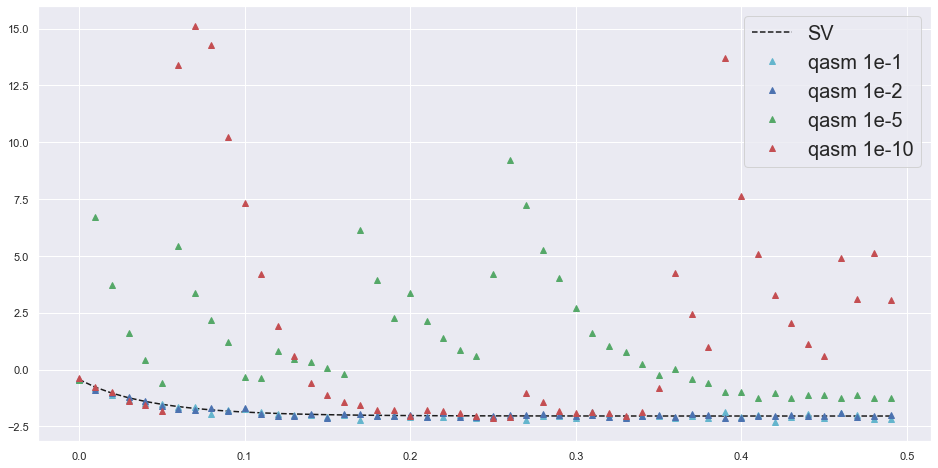

In [4]:
time=[delta_time*t for t in range(num_iterations)]
plt.plot(time,sv_energies,'k--',label="SV")
plt.plot(time,Energy_table[0],'c^',label="qasm 1e-1")
plt.plot(time,Energy_table[1],'b^',label="qasm 1e-2")
plt.plot(time,Energy_table[2],'g^',label="qasm 1e-5")
plt.plot(time,Energy_table[3],'r^',label="qasm 1e-10")
plt.legend(prop={'size': 20})

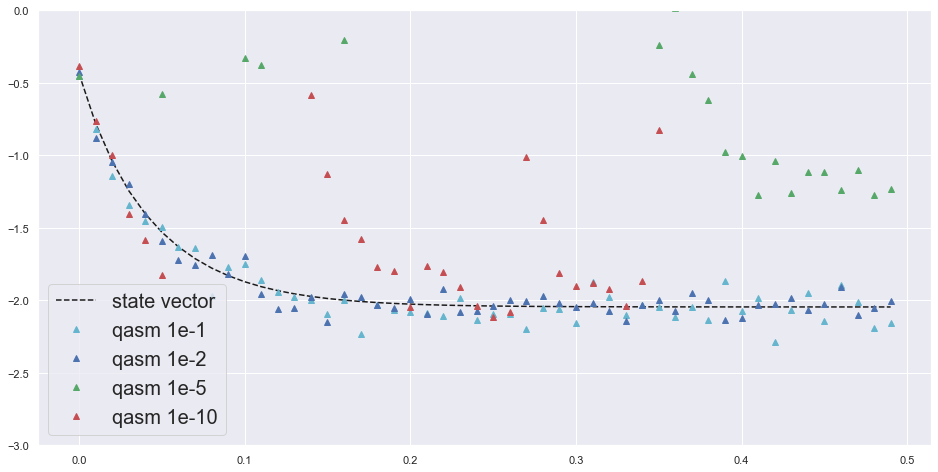

In [5]:
time=[delta_time*t for t in range(num_iterations)]
plt.plot(time,sv_energies,'k--',label="state vector")
plt.plot(time,Energy_table[0],'c^',label="qasm 1e-1")
plt.plot(time,Energy_table[1],'b^',label="qasm 1e-2")
plt.plot(time,Energy_table[2],'g^',label="qasm 1e-5")
plt.plot(time,Energy_table[3],'r^',label="qasm 1e-10")
plt.ylim(-3,0)
plt.legend(prop={'size': 20})

In [6]:
### Testing  time steps 
num_iterations=50
verbose=False
initialization="zeros"

Energy_table_time_sv=[]
Energy_table_time_qasm=[]

H = hamiltonian_matrix(Nmax=6,hw=7.0,J=1,interaction_filename="toy_hamiltonian") 
H_qubit = GrayCodeHamiltonian(H)

# backend = 'statevector_simulator'
# sv_energies=run_qite_experiment(H,num_iterations,delta_time,backend,initialization,A_threshold=1e-10)

for delta_time in [0.001,0.01,0.05]:
    backend = 'qasm_simulator'
    Energies,_=run_qite_experiment(H_qubit,num_iterations,delta_time,backend,initialization,A_threshold=1e-2)
    Energy_table_time_qasm.append(Energies)

    backend = 'statevector_simulator'
    Energies,_=run_qite_experiment(H_qubit,num_iterations,delta_time,backend,initialization,A_threshold=1e-2)
    Energy_table_time_sv.append(Energies)

    


100%|██████████| 50/50 [00:08<00:00,  5.56it/s]


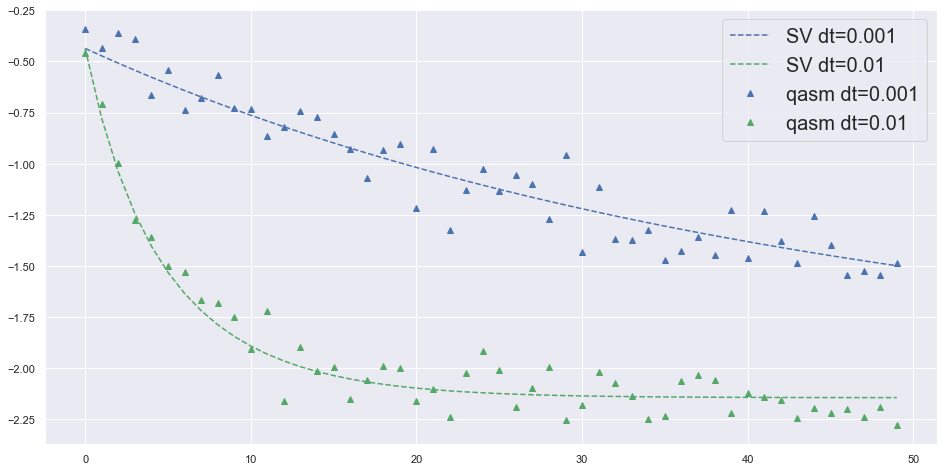

In [7]:
# num_iterations=100
# delta_time=0.01
time=[t for t in range(num_iterations)]
# plt.plot(time,sv_energies,'r--',label="state vector")
plt.plot(time,Energy_table_time_sv[0],'b--',label="SV dt=0.001")
plt.plot(time,Energy_table_time_sv[1],'g--',label="SV dt=0.01")
# plt.plot(time,Energy_table_time_sv[2],'r--',label="SV dt=0.1")

plt.plot(time,Energy_table_time_qasm[0],'b^',label="qasm dt=0.001")
plt.plot(time,Energy_table_time_qasm[1],'g^',label="qasm dt=0.01")
# plt.plot(time,Energy_table_time_qasm[2],'r^',label="qasm dt=0.1")
plt.legend(prop={'size': 20})

(-3.0, 0.0)

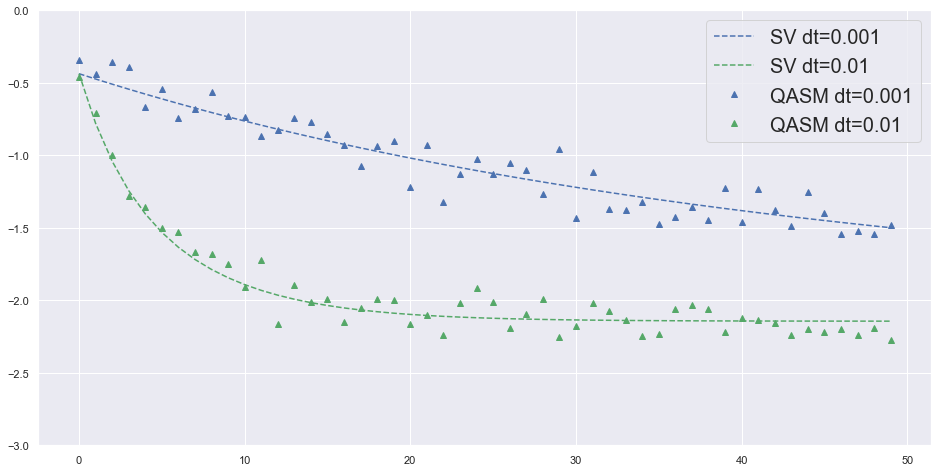

In [8]:

time=[t for t in range(num_iterations)]
plt.plot(time,Energy_table_time_sv[0],'b--',label="SV dt=0.001")
plt.plot(time,Energy_table_time_sv[1],'g--',label="SV dt=0.01")
# plt.plot(time,Energy_table_time_sv[2],'r--',label="SV dt=0.01")

plt.plot(time,Energy_table_time_qasm[0],'b^',label="QASM dt=0.001")
plt.plot(time,Energy_table_time_qasm[1],'g^',label="QASM dt=0.01")
# plt.plot(time,Energy_table_time_qasm[2],'r^',label="QASM dt=0.1")

plt.legend(prop={'size': 20})
plt.ylim(-3,0)

In [9]:
### Testing  time steps 
num_iterations=50
verbose=False
initialization="zeros"

Energy_table_time_sv=[]
Energy_table_time_qasm=[]

H = hamiltonian_matrix(Nmax=6,hw=7.0,J=1,interaction_filename="toy_hamiltonian") 
H_qubit = GrayCodeHamiltonian(H)

# backend = 'statevector_simulator'
# sv_energies=run_qite_experiment(H,num_iterations,delta_time,backend,initialization,A_threshold=1e-10)

for delta_time in [0.05]:
#     backend = 'qasm_simulator'
#     Energies,_=run_qite_experiment(H_qubit,num_iterations,delta_time,backend,initialization,A_threshold=1e-2)
#     Energy_table_time_qasm.append(Energies)

    backend = 'statevector_simulator'
    Energies,_=run_qite_experiment(H_qubit,num_iterations,delta_time,backend,initialization,A_threshold=1e-2)
    Energy_table_time_sv.append(Energies)

    


100%|██████████| 50/50 [00:13<00:00,  3.78it/s]


In [10]:
## Combining A 
num_iterations=50
delta_time=0.01
verbose=False
backend = 'statevector_simulator'
initialization="zeros"

Energy_table_step=[]
H = hamiltonian_matrix(Nmax=4,hw=7.0,J=1,interaction_filename="toy_hamiltonian") 
H_qubit = GrayCodeHamiltonian(H)


for cs in range(0,num_iterations,10):
    if cs==0:
        cs=None
    Energies,_=run_qite_experiment(H_qubit,num_iterations,delta_time,backend,initialization,A_threshold=1e-2,cstep=cs)
    Energy_table_step.append(Energies)

100%|██████████| 50/50 [00:07<00:00,  7.07it/s]


0
10
20
30
40


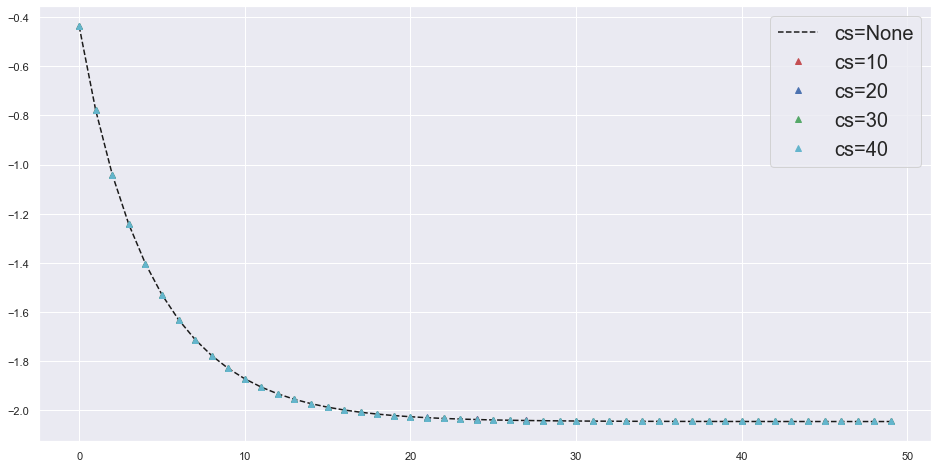

In [11]:
for cs in range(0,50,10):
    print(cs)
# num_iterations=100
# delta_time=0.01
time=[t for t in range(num_iterations)]
plt.plot(time,Energy_table_step[0],'k--',label="cs=None")
plt.plot(time,Energy_table_step[1],'r^',label="cs=10")
plt.plot(time,Energy_table_step[2],'b^',label="cs=20")
plt.plot(time,Energy_table_step[4],'g^',label="cs=30")
plt.plot(time,Energy_table_step[4],'c^',label="cs=40")
plt.plot()
plt.legend(prop={'size': 20})

0
5
10
15
20
25


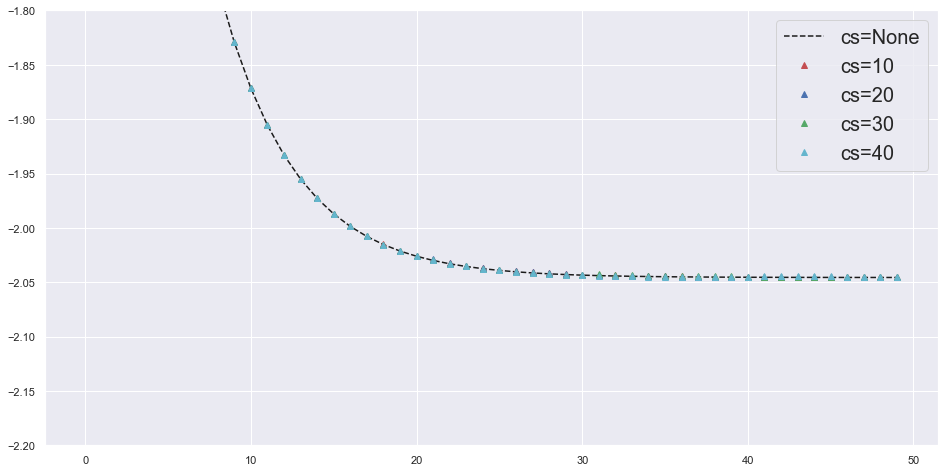

In [12]:
for cs in range(0,30,5):
    print(cs)
# num_iterations=100
# delta_time=0.01
time=[t for t in range(num_iterations)]
plt.plot(time,Energy_table_step[0],'k--',label="cs=None")
plt.plot(time,Energy_table_step[1],'r^',label="cs=10")
plt.plot(time,Energy_table_step[2],'b^',label="cs=20")
plt.plot(time,Energy_table_step[3],'g^',label="cs=30")
plt.plot(time,Energy_table_step[4],'c^',label="cs=40")
plt.ylim(-2.2,-1.8)
plt.plot()
plt.legend(prop={'size': 20})


In [13]:
## Combining A 
num_iterations=50
delta_time=0.01
verbose=False
backend = 'qasm_simulator'
initialization="zeros"

Energy_table_step_qasm=[]
H = hamiltonian_matrix(Nmax=4,hw=7.0,J=1,interaction_filename="toy_hamiltonian") 
H_qubit = GrayCodeHamiltonian(H)


for cs in range(0,num_iterations,10):
    if cs==0:
        cs=None
    Energies,_=run_qite_experiment(H_qubit,num_iterations,delta_time,backend,initialization,A_threshold=1e-2,cstep=cs)
    Energy_table_step_qasm.append(Energies)

100%|██████████| 50/50 [00:51<00:00,  1.04s/it]


0
10
20
30
40


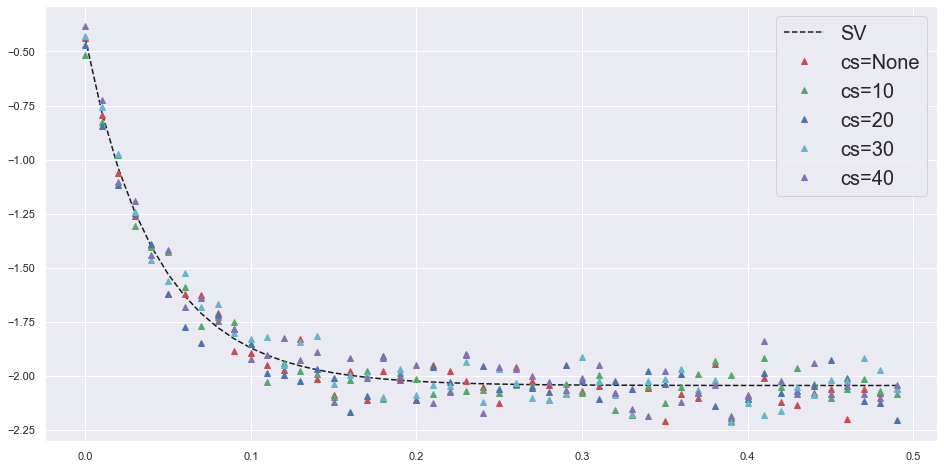

In [14]:
for cs in range(0,50,10):
    print(cs)
# num_iterations=100
# delta_time=0.01
time=[0.01*t for t in range(num_iterations)]
plt.plot(time,sv_energies,'k--',label="SV")
plt.plot(time,Energy_table_step_qasm[0],'r^',label="cs=None")
plt.plot(time,Energy_table_step_qasm[1],'g^',label="cs=10")
plt.plot(time,Energy_table_step_qasm[2],'b^',label="cs=20")
plt.plot(time,Energy_table_step_qasm[3],'c^',label="cs=30")
plt.plot(time,Energy_table_step_qasm[4],'m^',label="cs=40")
plt.plot()
plt.legend(prop={'size': 20})

## N=8

In [15]:
num_iterations=100
delta_time=0.01
verbose=False
backend = 'statevector_simulator'
initialization="zeros"

H = hamiltonian_matrix(Nmax=14,hw=7.0,J=1,interaction_filename="toy_hamiltonian") 
H_qubit = GrayCodeHamiltonian(H)
n_qubits=H_qubit.N_qubits
print(n_qubits)

sv_energies,_=run_qite_experiment(H_qubit,num_iterations,delta_time,backend,initialization,A_threshold=1e-10)
print(sv_energies)


  0%|          | 0/100 [00:00<?, ?it/s]

3


100%|██████████| 100/100 [03:26<00:00,  2.07s/it]

[-0.43658111 -0.77894713 -1.04043191 -1.24347644 -1.40344734 -1.53112215
 -1.63421097 -1.71832527 -1.78761236 -1.84518049 -1.8933892  -1.93405088
 -1.9685729  -1.99805925 -2.02338403 -2.04524541 -2.06420554 -2.08072045
 -2.09516271 -2.10783869 -2.11900188 -2.12886326 -2.13759939 -2.14535878
 -2.15226704 -2.15843086 -2.16394132 -2.1688765  -2.17330365 -2.17728089
 -2.18085868 -2.18408098 -2.18698622 -2.18960812 -2.19197636 -2.19411712
 -2.19605358 -2.19780633 -2.19939364 -2.20083185 -2.20213552 -2.20331769
 -2.20439004 -2.20536308 -2.20624623 -2.207048   -2.20777602 -2.20843722
 -2.20903781 -2.20958344 -2.2100792  -2.21052969 -2.21093909 -2.21131119
 -2.21164939 -2.21195683 -2.2122363  -2.21249037 -2.21272135 -2.21293136
 -2.2131223  -2.21329591 -2.21345377 -2.21359732 -2.21372784 -2.21384653
 -2.21395445 -2.2140526  -2.21414185 -2.21422301 -2.21429682 -2.21436394
 -2.21442498 -2.21448049 -2.21453097 -2.21457687 -2.21461862 -2.21465659
 -2.21469112 -2.21472252 -2.21475108 -2.21477705 -2

In [16]:
num_iterations=100
delta_time=0.01
verbose=False
backend = 'statevector_simulator'
initialization="zeros"
H = hamiltonian_matrix(Nmax=14,hw=7.0,J=1,interaction_filename="toy_hamiltonian") 
H_qubit = GrayCodeHamiltonian(H)
n_qubits=H_qubit.N_qubits
print(n_qubits)


sv_energies_table_cs=[]
for cs in range(10,51,10):
    sv_energies_table_cs.append(run_qite_experiment(H_qubit,num_iterations,delta_time,backend,initialization,cstep=cs)[0])

  0%|          | 0/100 [00:00<?, ?it/s]

3


100%|██████████| 100/100 [01:44<00:00,  1.04s/it]


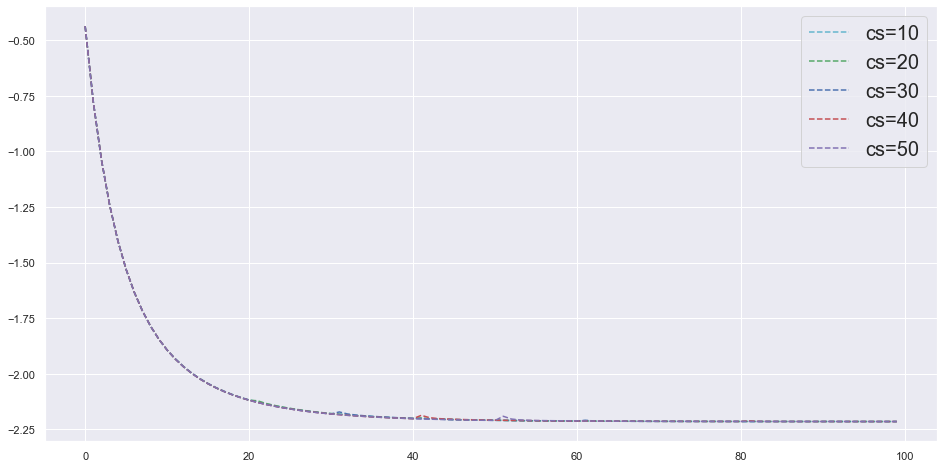

In [17]:
time=[t for t in range(num_iterations)]
# plt.plot(time,sv_energies,'k--',label="SV")
plt.plot(time,sv_energies_table_cs[0],'c--',label="cs=10")
plt.plot(time,sv_energies_table_cs[1],'g--',label="cs=20")
plt.plot(time,sv_energies_table_cs[2],'b--',label="cs=30")
plt.plot(time,sv_energies_table_cs[3],'r--',label="cs=40")
plt.plot(time,sv_energies_table_cs[4],'m--',label="cs=50")
plt.legend(prop={'size': 20})

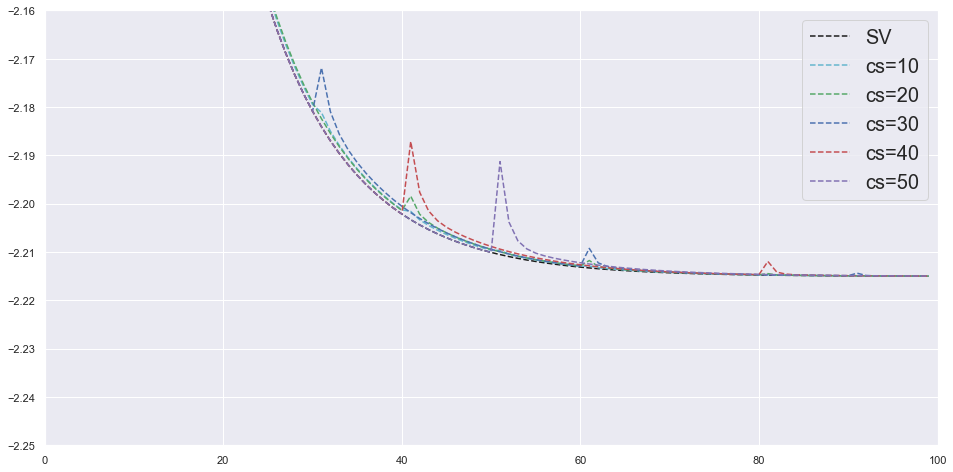

In [18]:
time=[t for t in range(num_iterations)]
plt.plot(time,sv_energies,'k--',label="SV")
plt.plot(time,sv_energies_table_cs[0],'c--',label="cs=10")
plt.plot(time,sv_energies_table_cs[1],'g--',label="cs=20")
plt.plot(time,sv_energies_table_cs[2],'b--',label="cs=30")
plt.plot(time,sv_energies_table_cs[3],'r--',label="cs=40")
plt.plot(time,sv_energies_table_cs[4],'m--',label="cs=50")
plt.xlim(0,100)
plt.ylim(-2.25,-2.16)
plt.legend(prop={'size': 20})

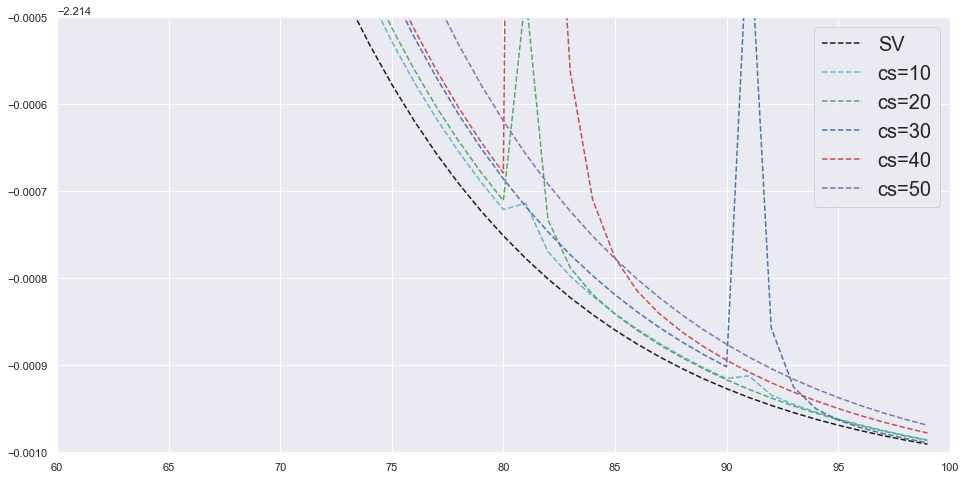

In [19]:
time=[t for t in range(num_iterations)]
plt.plot(time,sv_energies,'k--',label="SV")
plt.plot(time,sv_energies_table_cs[0],'c--',label="cs=10")
plt.plot(time,sv_energies_table_cs[1],'g--',label="cs=20")
plt.plot(time,sv_energies_table_cs[2],'b--',label="cs=30")
plt.plot(time,sv_energies_table_cs[3],'r--',label="cs=40")
plt.plot(time,sv_energies_table_cs[4],'m--',label="cs=50")
plt.xlim(60,100)
plt.ylim(-2.2150,-2.2145)
plt.legend(prop={'size': 20})

In [22]:
num_iterations=100
delta_time=0.01
verbose=False
backend = 'statevector_simulator'
initialization="zeros"

Nmax=4
H = hamiltonian_matrix(Nmax,7.0,1,"toy_hamiltonian") 
H_qubit = GrayCodeHamiltonian(H)
n_qubits=H_qubit.N_qubits
sv_energies_3q_100=run_qite_experiment(H_qubit,num_iterations,delta_time,backend,initialization,A_threshold=1e-2,cstep=cs)[0]

100%|██████████| 100/100 [00:18<00:00,  5.45it/s]


In [23]:
num_iterations=100
delta_time=0.01
verbose=False
backend = 'qasm_simulator'
initialization="zeros"

qasm_energies_table_cs=[]

H = hamiltonian_matrix(Nmax=4,hw=7.0,J=1,interaction_filename="toy_hamiltonian") 
H_qubit = GrayCodeHamiltonian(H)
n_qubits=H_qubit.N_qubits

for cs in range(10,31,10):
    qasm_energies_table_cs.append(run_qite_experiment(H_qubit,num_iterations,delta_time,backend,initialization,A_threshold=1e-2,cstep=cs)[0])

100%|██████████| 100/100 [01:19<00:00,  1.27it/s]


In [ ]:
time=[t for t in range(num_iterations)]
plt.plot(time,sv_energies_3q_100,'k--',label="SV")
plt.plot(time,qasm_energies_table_cs[0],'c^',label="cs=10")
plt.plot(time,qasm_energies_table_cs[1],'g^',label="cs=20")
plt.plot(time,qasm_energies_table_cs[2],'b^',label="cs=30")
# plt.xlim(60,100)
# plt.ylim(-2.2151,-2.2145)
plt.legend(prop={'size': 20})

In [ ]:
num_iterations=50
delta_time=0.01
verbose=False

initialization="zeros"
H = hamiltonian_matrix(Nmax=4,hw=7.0,J=1,interaction_filename="toy_hamiltonian") 
H_qubit = GrayCodeHamiltonian(H)
n_qubits=H_qubit.N_qubits

backend = 'qasm_simulator'
qasm_energies_q3,_=run_qite_experiment(H_qubit,num_iterations,delta_time,backend,initialization,A_threshold=1e-2,cstep=None)
backend = 'statevector_simulator'
sv_energies_q3,_=run_qite_experiment(H_qubit,num_iterations,delta_time,backend,initialization,cstep=None)

In [ ]:
time=[t for t in range(num_iterations)]
plt.plot(time,sv_energies_q3,'k--',label="SV")
plt.plot(time,qasm_energies_q3,'c^',label="qasm")
plt.legend(prop={'size': 20})